# Identifying Playlist Themes via Clustering

Our belief in generating playlists is that each playlist should have a theme, which we thought would be best represented by clustering songs. With these clusters, we could assume that songs are similar along some dimensions identified by the unsupervised machine learning algorithm and would go well together on a single playlist. We explored several methods of clustering to see how granularly we could separate songs and to test our hypothesis that an unsupervised algorithm could successfully identify unique traits about our collection of songs.

In [1]:
# Import packages necessary for clustering
import numpy as np
import pandas as pd
import time
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join

import scipy.sparse

sns.set()
%matplotlib inline

In [4]:
# Load master song table with added metadata
master = pd.read_pickle('../data/master200.pkl')
master_reduced = pd.read_pickle('../data/master_reduced.pkl')

song_ids = master_reduced.index.values
cont_feats = list(master_reduced.drop(['artist_name', 'album_name'], 1).columns)

encoded_cont = np.load('../data/encoded_cont_5wide.npy', allow_pickle = True)

indicators = scipy.sparse.load_npz('../data/indicators.npz')

# t-SNE Visual Representation

We wanted to consider a clustering method that would allow us to produce a 2-Dimensional graph representation of our clusters so that we could visually explore and confirm if separation existed between the produced clusters. To do this, we used the technique t-Distributed Stochastic Neighbor Embedding (t-SNE). t-SNE applies dimension reductionality probabilistically, in comparison to Principal Component Analysis (PCA) which applies a mathematical function to calculate the direction of minimum error.

t-SNE is a computationally intensive technique because it looks at data distributions and attempts to calculate similar representations with fewer dimensions for each dimension. Because of this, we found more success applying other dimension reduction or clustering techniques first and passing the input of that into t-SNE for further reduction and subsequent visualization. This process allowed us to create a measure of standardization across the two clustering techniques we tried as well, giving us a relative definition of success to use for continued refinement.

As presented in the prior section, we invested heavily in exploring and choosing strong dimensionality reduction such that we could introduce a manageable dataframe to t-SNE. 

In [31]:
# Data already shuffled, so we can pull a random subset of train data for visualisation
np.random.seed(42)
tsne_ind = np.random.choice(np.arange(encoded_cont.shape[0]), 10000)

In [18]:
from sklearn.manifold import TSNE
time_start = time.time()

tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
#tsne = TSNE(n_components = 2, verbose = 1, n_iter = 300)

tsne_results = tsne.fit_transform(encoded_cont[tsne_ind])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 0.493s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.048215
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.582054
[t-SNE] KL divergence after 300 iterations: 2.652236
t-SNE done! Time elapsed:

In [8]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components = 2, verbose = 0, perplexity = 50, n_iter = 300)
#tsne = TSNE(n_components = 2, verbose = 1, n_iter = 300)
tsne_results = tsne.fit_transform(encoded_cont)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

todo should I have an initial TSNE chart here?

# K-Means Clustering

K-Means was our initial clustering model, serving as our baseline playlist generation algorithm and as a core input into our final playlist algorithm.

K-Means requires the manual specification of a target number of clusters, which we selected to be 10. This presented an initial challenge as we became familiar with our data, not knowing how many clusters was a reasonable target, but through parameter tuning we were able to choose a selection that represented sufficient separation. The algorithm then identifies the closest cluster center (called the centroid) for every data point and labels that data point as a member of that cluster. It optimizes the identified clusters by minimizing the cluster's sum of squares so that each cluster will be as narrow and focused as possible.

Our baseline playlist generation algorithm consisted of basic K-Means clustering, whereby we clustered songs by the properties available after our cleaning and transformation process. A user could then provide a handful of songs to cold start the playlist, after which we'd select future songs from the same cluster as the provided songs until our playlist was full.

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_jobs = -1, n_clusters = 15, n_init = 20, 
                max_iter = 300, random_state = 42, verbose = 0)

kmeans.fit(encoded_cont)

cluster_centers = kmeans.cluster_centers_
k_labels = kmeans.labels_

In [11]:
# Sizes of fit clusters (num songs in each)
clust, count = np.unique(k_labels, return_counts = True)
for cl, co in zip(clust, count):
    print(cl, ':', co)

0 : 17434
1 : 7447
2 : 16620
3 : 10878
4 : 17170
5 : 10155
6 : 12500
7 : 20787
8 : 12098
9 : 11318
10 : 21551
11 : 5942
12 : 20485
13 : 8673
14 : 20617


In [30]:
print(tsne_ind)

[121958 146867 131932 ...  20365  39029   1737]


In [20]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[tsne_ind, 0], 
    y = tsne_results[tsne_ind, 1],
    hue = k_labels[tsne_ind],
    palette = sns.color_palette("hls", len(np.unique(k_labels[tsne_ind]))),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of K-Means clusters of 10,000 songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')

# plt.savefig('kmeans_subset.pdf')

IndexError: index 121958 is out of bounds for axis 0 with size 10000

<Figure size 720x576 with 0 Axes>

## K-Means Assessment

K-Means provides us with the provided number of clusters but few of these appear to maintain any sort of distance separation from other clusters, suggesting that they may be more intertwined than we'd like. For playlist generation, we can leverage K-Means and the assumption that even if these songs are extremely distinct, they are still the *most* similar songs. This assumption works for song selection because even if most songs are similar across genres, a pop song will still be more similar to another pop song than it will be to a death metal song.

# HDBSCAN Clustering

HDBSCAN is a library of software tools that implements a clustering algorithm developed by [Campello, Moulavi, and Sander](http://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14). It is a powerful step above K-Means in that it does not require you to specify the number of clusters, but instead analyzes density distribution, assumes a certain level of noise, and returns only clusters of data that reach a certain threshold of density. Given the diversity of song styles, our hypothesis was that there would be a large number of "noise" songs, songs that don't fit into an identifiable category and that are best ignored when generating a playlist with a desired theme. What should remain after HDBSCAN are clusters of songs that are similar enough to have an enjoyable thematic experience in our new playlist.

To better understand the HDBSCAN algorithm, let's explore its process step-by-step. First, HDBSCAN estimates density using distance to *k*th nearest neighbors, referred to in the literature as *core distance*. A second distance metric, referred to as *mutual reachability distance*, is calculated that spreads sparse points farther away while leaving denser points relatively untouched. **todo should we go into this level of detail?**

In [16]:
import hdbscan as h

hdb = h.HDBSCAN(min_cluster_size = 100, cluster_selection_method = 'leaf')

hdb.fit(encoded_cont)

print("Number of clusters:", np.max(hdb.labels_)+1)

Number of clusters: 18


In [17]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[tsne_ind, 0], 
    y = tsne_results[tsne_ind, 1],
    hue = hdb.labels_[tsne_ind],
    palette = sns.color_palette("hls", len(np.unique(hdb.labels_[tsne_ind]))),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of HDBSCAN clusters of 10,000 songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')
# plt.savefig('hdbscan_subset.pdf')

IndexError: index 121958 is out of bounds for axis 0 with size 10000

<Figure size 720x576 with 0 Axes>

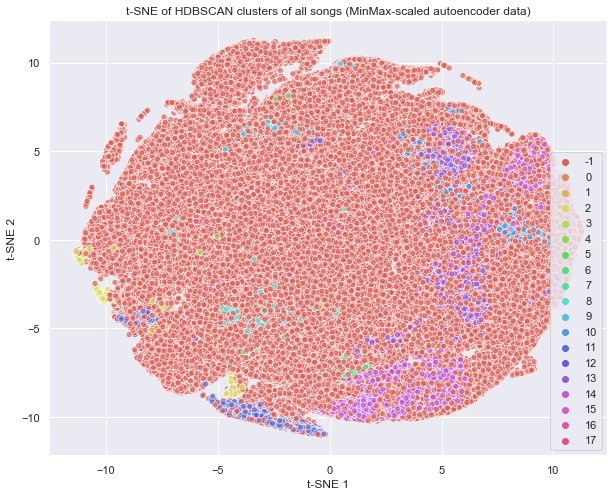

In [160]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[:, 0], 
    y = tsne_results[:, 1],
    hue = hdb.labels_,
    palette = sns.color_palette("hls", len(np.unique(hdb.labels_))),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of HDBSCAN clusters of all songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')
# plt.savefig('hdbscan_all.pdf')

### HDBSCAN Assessment

In contrast to the generated K-Means clusters, we immediately see that HDBSCAN produces very different results thanks to its inclusion of the concept of noise. Any song marked as belonging to cluster *-1* is classified as noise and the vast majority of songs are classified into this cluster by HDBSCAN.

The library does identify five major song clusters (those that are colored pink, purple, blue, teal and yellow). This suggests that there are certain types of songs that are highly similar in their melody, tempo or other song attributes but that on the whole, there is not enough density to group most songs into a confident cluster. This presents challenges for our playlist generation algorithm, as our hypothesis rests on songs being similar enough to allow like selection.

# Clustering Conclusion

After trying to cluster songs by three distinct methods, we're left with the feeling that based on the song attributes we have collected, it is challenging to identify distinct patterns of song in an absolute sense. HDBSCAN was able to identify a handle of small but dense clusters that we can have confidence are similar to each other but the majority of songs across genres are similar enough as to be undifferentiable. For playlist generation, we can still rely on relative differentiation to identify the next song selection.